In [6]:
# Pandas
import pandas as pd
pd.set_option('display.max_colwidth', None)

# Numpy
import numpy as np

# Plotly
import plotly.graph_objects as go

# Scikit learn
from sklearn import set_config
set_config(display='diagram')
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text

# Functions
def train_and_test(datasets, classifier, param_grid, scoring='accuracy', n_jobs=10, return_train_score=True):
    model = {}
    results = {}
    
    for key in datasets:
        model[key] = {}
        results[key] = {}
        
        # Grid search
        model[key]["model_ohe_grid"] = GridSearchCV(classifier, param_grid, scoring=scoring, n_jobs=n_jobs, return_train_score=return_train_score).fit(datasets[key]["X_train_ohe"], datasets[key]["Y_train"])
        model[key]["model_le_grid"] = GridSearchCV(classifier, param_grid, scoring=scoring, n_jobs=n_jobs, return_train_score=return_train_score).fit(datasets[key]["X_train_le"], datasets[key]["Y_train"])
        model[key]["model_ohe"] = model[key]["model_ohe_grid"].best_estimator_
        model[key]["model_le"] = model[key]["model_le_grid"].best_estimator_

        # Test
        results[key]["ohe"] = model[key]['model_ohe'].score(datasets[key]['X_test_ohe'], datasets[key]['Y_test'])
        results[key]["le"] = model[key]['model_le'].score(datasets[key]['X_test_le'], datasets[key]['Y_test'])
    
    return model, results

def plot_results(results, title):
    fig = go.Figure()
    results = pd.DataFrame(results)
    for col in results:
        fig.add_traces(go.Bar(y=results.index, x=results[col], orientation="h", name=col))
    fig.update_layout(title=title, xaxis = dict(range=[0.5, 0.9]))
    return fig 

def acc_analysis(datasets, model_dict, param_name):
    analysis = {param_name: [], 'enc': [], 'test': [], 'train': []}
    for key in datasets:
        for param in model_dict[key]["model_ohe_grid"].cv_results_["params"]:
            analysis[param_name].append(param[param_name])
            analysis['enc'].append('ohe')
            analysis['test'].append(model_dict[key]["model_ohe_grid"].cv_results_["mean_test_score"][model_dict[key]["model_ohe_grid"].cv_results_["params"].index(param)])
            analysis['train'].append(model_dict[key]["model_ohe_grid"].cv_results_["mean_train_score"][model_dict[key]["model_ohe_grid"].cv_results_["params"].index(param)])
        for param in model_dict[key]["model_le_grid"].cv_results_["params"]:
            analysis[param_name].append(param[param_name])
            analysis['enc'].append('le')
            analysis['test'].append(model_dict[key]["model_le_grid"].cv_results_["mean_test_score"][model_dict[key]["model_le_grid"].cv_results_["params"].index(param)])
            analysis['train'].append(model_dict[key]["model_le_grid"].cv_results_["mean_train_score"][model_dict[key]["model_le_grid"].cv_results_["params"].index(param)])

    analysis_train = pd.pivot_table(pd.DataFrame(analysis), index=param_name, columns="enc", values="train", aggfunc=np.mean)
    analysis_test = pd.pivot_table(pd.DataFrame(analysis), index=param_name, columns="enc", values="test", aggfunc=np.mean)

    fig = go.Figure()
    for enc in analysis_train:
        fig.add_traces(go.Scatter(x=analysis_train.index, y=analysis_train[enc], name=f"Train - {enc}"))

    for enc in analysis_test:
        fig.add_traces(go.Scatter(x=analysis_test.index, y=analysis_test[enc], name=f"Test - {enc}"))

    return fig
    
def my_print_tree(tree, feature_names):
    print(export_text(tree, feature_names=feature_names))

# Adult Census Income - Classification

## Table of Contents

1. [Introduction](#Introduction)
  - [Reading the data](#Reading-the-data)
  - [Training and testing process](#Training-and-testing-process)
2. [Logistic Regression](#Logistic-Regression)
  - [Theory recall](#logreg-theory)
  - [Parameters](#logreg-parameters)
  - [Testing](#logreg-testing)
  - [Conclusions](#logreg-conclusions)
3. [Linear Discriminant Analysis](#Linear-Discriminant-Analysis)
  - [Theory recall](#lda-theory)
  - [Parameters](#lda-parameters)
  - [Testing](#lda-testing)
  - [Conclusions](#lda-conclusions)
4. [K-Nearest Neighbors](#K-Nearest-Neighbors)
  - [Theory recall](#knn-theory)
  - [Parameters](#knn-parameters)
  - [Testing](#knn-testing)
  - [Conclusions](#knn-conclusions)
5. [Decision Trees](#Decision-Trees)
  - [Theory recall](#dt-theory)
  - [Parameters](#dt-parameters)
  - [Testing](#dt-testing)
  - [Conclusions](#dt-conclusions)
6. [Random Forest](#Random-Forest)
  - [Theory recall](#rf-theory)
  - [Parameters (trees)](#rf-parameters-trees)
  - [Testing (trees)](#rf-testing-trees)
  - [Parameters (depth)](#rf-parameters-depth)
  - [Testing (depth)](#rf-testing-depth)
  - [Conclusions](#rf-conclusions)
7. [Future Work](#Future-Work)

## Introduction

### Reading the data

In the previous notebook, we generated different datasets according to the different strategies of feature engineering we are trying to compare. The only step we still haven't performed is encoding; therefore, we can now read the data and encode it using both a label encoder and a one hot encoder. In this step, Xs and ys has also been separated for the next phases.

In [2]:
# Read the datasets
datasets = {}
datasets_keys = ["original", "clean", "drop", "drop_bin", "drop_discr", "drop_bin_discr", "impute", "impute_bin", "impute_discr", "impute_bin_discr"]

# Read and encode
for key in datasets_keys:
    datasets[key] = {}
    datasets[key]["X_train"] = pd.read_csv(f"datasets/{key}/train.csv")
    datasets[key]["X_test"] = pd.read_csv(f"datasets/{key}/test.csv")
    
    # Save target variable as 0 / 1 codes
    datasets[key]["Y_train"] = datasets[key]["X_train"].income.astype("category").cat.codes
    datasets[key]["Y_test"] = datasets[key]["X_test"].income.astype("category").cat.codes
    
    # One Hot Encoding
    datasets[key]["X_train_ohe"] = datasets[key]["X_train"].copy().drop(columns=["income"])
    datasets[key]["X_test_ohe"] = datasets[key]["X_test"].copy().drop(columns=["income"])
    for col in datasets[key]["X_train_ohe"].select_dtypes("object").columns:
        if len(datasets[key]["X_train_ohe"][col].unique()) == 2:
            datasets[key]["X_train_ohe"][col] = datasets[key]["X_train_ohe"][col].astype("category").cat.codes
            datasets[key]["X_test_ohe"][col] = datasets[key]["X_test_ohe"][col].astype("category").cat.codes
    datasets[key]["X_train_ohe"] = pd.get_dummies(datasets[key]["X_train_ohe"])
    datasets[key]["X_test_ohe"] = pd.get_dummies(datasets[key]["X_test_ohe"])
    
    # Label Encoding
    datasets[key]["X_train_le"] = datasets[key]["X_train"].copy().drop(columns=["income"])
    datasets[key]["X_test_le"] = datasets[key]["X_test"].copy().drop(columns=["income"])
    for col in datasets[key]["X_train_le"].select_dtypes("object").columns:
        datasets[key]["X_train_le"][col] = datasets[key]["X_train_le"][col].astype("category").cat.codes
        datasets[key]["X_test_le"][col] = datasets[key]["X_test_le"][col].astype("category").cat.codes
    
    del datasets[key]["X_train"]
    del datasets[key]["X_test"]

### Training and testing process

The general process that I have followed to find the best model for the given data is the following:

- Load the data (already split into train and test sets in the previous notebook)
- Encode all the splits (label encoder and one hot encoder to compare them)
- Define different parameters to be tuned for each model
- Conduct a **GridSearchCV** to find the best params for each kind of feature engineering dataset ('best' evaluated in terms of *accuracy*)
- Evaluate the best models, on the test set, and compare the accuracies

## Logistic Regression

<span id="logreg-theory" />

### Theory recall

Since our target variable is categorical with only two classes, linear regression doesn't work very well (because the generated output isn't between 0 and 1) and logistic regression is more appropriate; this algorithm, rather than modeling the response directly, it models the *probability* that the target variable belongs to a particular class:

$$p(X) = \frac{e^{\left(\beta_{0}+\beta_{1}X\right)}}{1+e^{\left(\beta_{0}+\beta_{1}X\right)}} = \frac{1}{1+e^{-\left(\beta_{0}+\beta_{1}X\right)}}$$

If you look closely, you can see that this model is a linear function plugged into the sigmoid function (also called logistic function). In fact, the main difference between linear regression and logistic regression is that the output of the latter will always take values between 0 and 1: when the output is higher than 0.5, class 1 will be assigned, otherwise class 0 is assigned.

Manipulating the model equation, it is possible to obtain the *logit* transformation:

$$log\left(\frac{p(X)}{1-p(X)}\right) = \beta_{0}+\beta_{1}X$$

The regression coefficients are estimated maximizing a conditional ($P\left(y|X\right)$ *discriminative learning*) likelihood function: scikit learn's implementation minimizes the negative log likelihood function, which is a function called *cross-entropy*. Of course, with multiple predictors like in our case, the model is constructed on a linear combination of coefficients and predictors $\beta_{0}+\beta_{1}X_{1}+\beta_{2}X_{2}+...+\beta_{n}X_{n}$. (The likelihood function doesn't have a closed form; therefore an iterative process must be used.)

<span id="logreg-parameters" />

### Parameters

With the grid search, the following parameters have been optimized:

- *C*: this is the inverse of the regularization strength (sklearn models use regularization by default (better generalization))
- *solver* (check documentation [here](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression))

In [7]:
# Logistic Regression
logistic_regression, logistic_regression_results = train_and_test(
    datasets,
    LogisticRegression(max_iter=500),
    [{'C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100, 1000], 'solver': ['liblinear', 'lbfgs']}]
)

If we analyse how the accuracy evolves changing the *C* parameter, we can notice the following things:

- when C is too small, the model underfits (too much regularization)
- increasing C allows the model to be more accurate
- if C is too big the test accuracy decreases a little bit (overfitting, because almost no regularization) (slightly noticeable in one hot encoding when the two curves diverge)

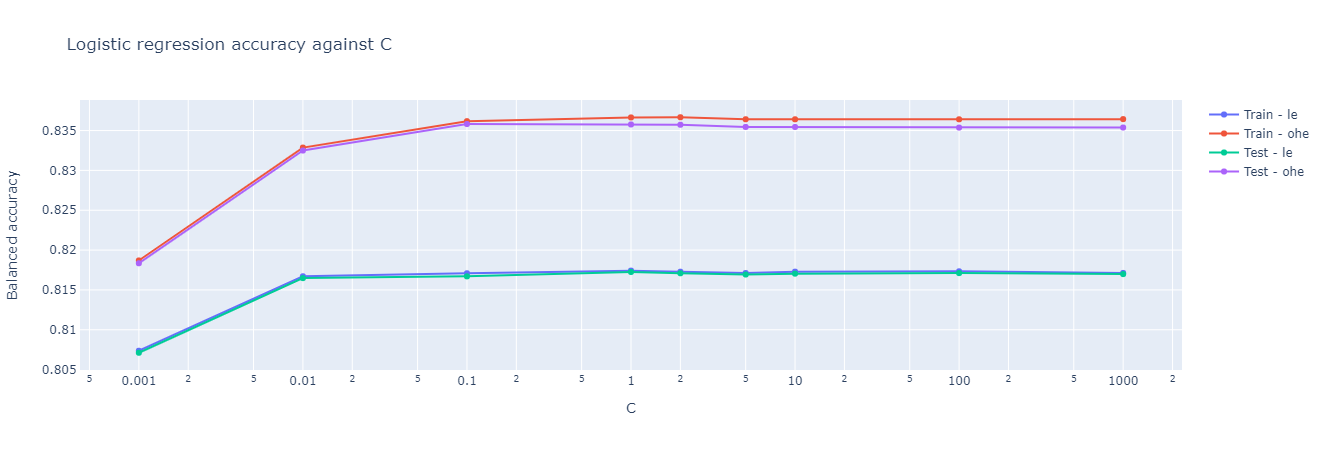

In [8]:
acc_analysis(datasets, logistic_regression, 'C').update_layout(xaxis_type="log", xaxis_title="C", yaxis_title="Balanced accuracy", title="Logistic regression accuracy against C")

<span id="logreg-testing" />

### Testing

Testing the best models of each *\"feature engineering type\"*, we obtain the accuracies reported in the plot below.

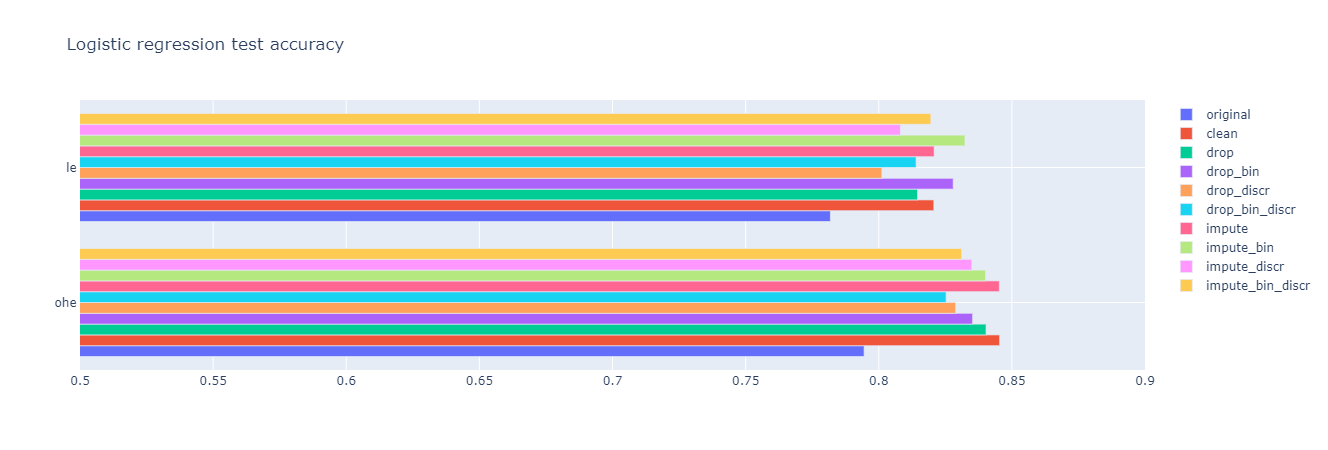

Best model:


LogisticRegression(C=0.1, max_iter=500, solver='liblinear')

In [9]:
# Plot
plot_results(logistic_regression_results, "Logistic regression test accuracy").show()
print("Best model:")
logistic_regression["clean"]["model_ohe"]

<span id="logreg-conclusions" />

### Conclusions

As we can see from the previous plot:

- the best model has achieved an accuracy of 84,5% on the *Clean* and *Impute* one-hot-encoded datasets
- one-hot-encoded datasets have performed, on average, better than label encoded ones (as we sad before, label encoding creates a magnitude relationship between classes that does not represent reality, hence performes poorly)
- the technique of imputing brought generally better results than dropping
- binning and discretizing don't seem to improve the overall model performance with one hot encoding

## Linear Discriminant Analysis

<span id="lda-theory" />

### Theory recall

*Discriminant analysis* is a probabilistic model whose approach is to estimate the distribution of each feature in the dataset, and then compute the posterior probability of the target class exploiting the Bayes theorem (which makes the assumption of independent features). Therefore, the predictions are made looking to the feature with the highest density. Bayes recall:

$$P\left(Y=k|X=x\right) = \frac{P\left(X=x|Y=k\right)*P\left(Y=k\right)}{P\left(X=x\right)} = \frac{\pi_{k}*f_{k}\left(x\right)}{\sum_{l=1}^{K}\pi_{l}*f_{l}\left(x\right)}$$

On the right part of the equation $f_{k}\left(x\right)$ is the *density* of $x$ when the class is $k$ and $\pi_{k}$ is the *marginal* probability of class $k$.

With multiple predictors like in our case, the model assumes that the input $X$ has a multivariate normal distribution, with distinct means and common covariance matrix; hence, the discriminant function has the form:

$$\delta_{k}\left(x\right) = x^{T}\Sigma^{-1}\mu_{k}-\frac{1}{2}\mu_{k}^{T}\Sigma^{-1}\mu_{k}+log\left(\pi_{k}\right)$$

To an observation $x$ will be assigned the class with the largest *discriminant score*:

$$\delta_{k}\left(x\right) = x*\frac{\mu_{k}}{\sigma^{2}} - \frac{\mu_{k}^{2}}{2\sigma^{2}} + log\left(\pi_{k}\right)$$

Linear discriminant analysis parameters are estimated using the full likelihood function ($P\left(X,y\right)$ *generative learning*).

<span id="lda-parameters" />

### Parameters

No parameters optimized with this model.

In [10]:
# Linear Discriminant Analysis
lda, lda_results = train_and_test(
    datasets,
    LinearDiscriminantAnalysis(),
    [{'solver': ['svd']}]
)

<span id="lda-testing" />

### Testing

Testing the best models of each *\"feature engineering type\"*, we obtain the accuracies reported in the plot below.

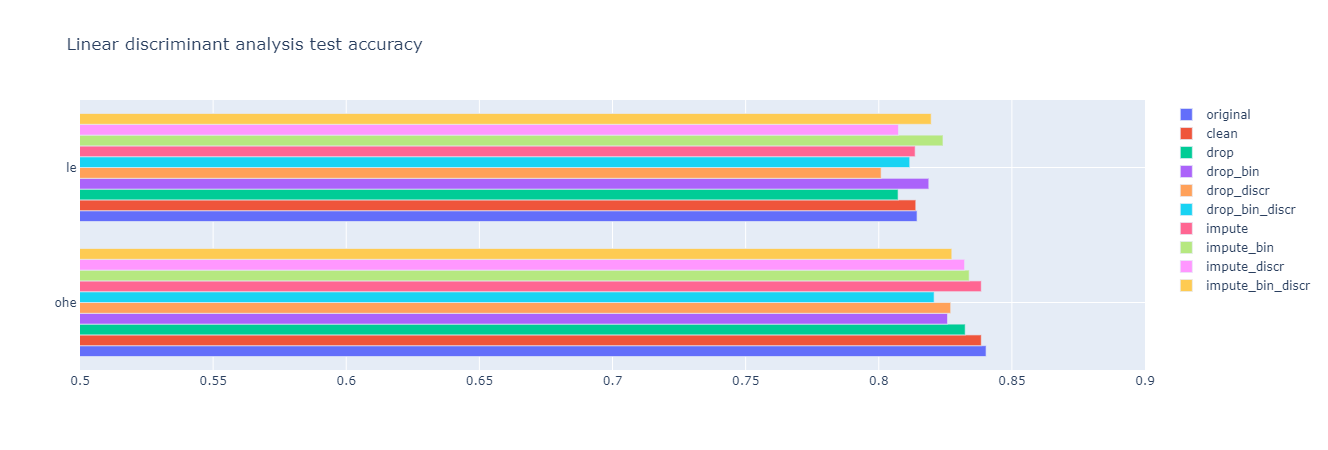

Best model: (default params)


LinearDiscriminantAnalysis()

In [11]:
# Plot
plot_results(lda_results, "Linear discriminant analysis test accuracy").show()
print("Best model: (default params)")
lda["original"]["model_ohe"]

<span id="lda-conclusions" />

### Conclusions

As we can see from the plot above:

- the best model has achieved an accuracy of 84% on the *Original* one-hot-encoded dataset
- as in logistic regression, on average, one hot encoding has performed better than label encoding

## K-Nearest Neighbors

<span id="knn-theory" />

### Theory recall

KNN is a non-parametric model that exploits the available data to make predictions; specifically, after having defined a proper distance measure, the model looks at the $K$ *nearest* points and then assigns the class by majority voting. The main drawback of this model, apart from the infering slowness, is that highdimensional space is empty, therefore, with a lot of variables, we cannot expect the model to perform very well. The main advantage is that the model is the training data.

<span id="knn-parameters" />

### Parameters

The only parameter to optimize is $K$.

In [ ]:
# KNN
knn, knn_results = train_and_test(
    datasets,
    KNeighborsClassifier(),
    [{'n_neighbors': [3, 5, 7, 9, 13, 17, 21, 25, 30, 40]}]
)

If we analyse how the accuracy evolves changing the *n_neighbors* parameter, we can notice the following things:

- when K is too small the model overfits (lack of generalization because looking at too few points)
- when K is too big the model underfits (not visible in our testing because not so big Ks used)

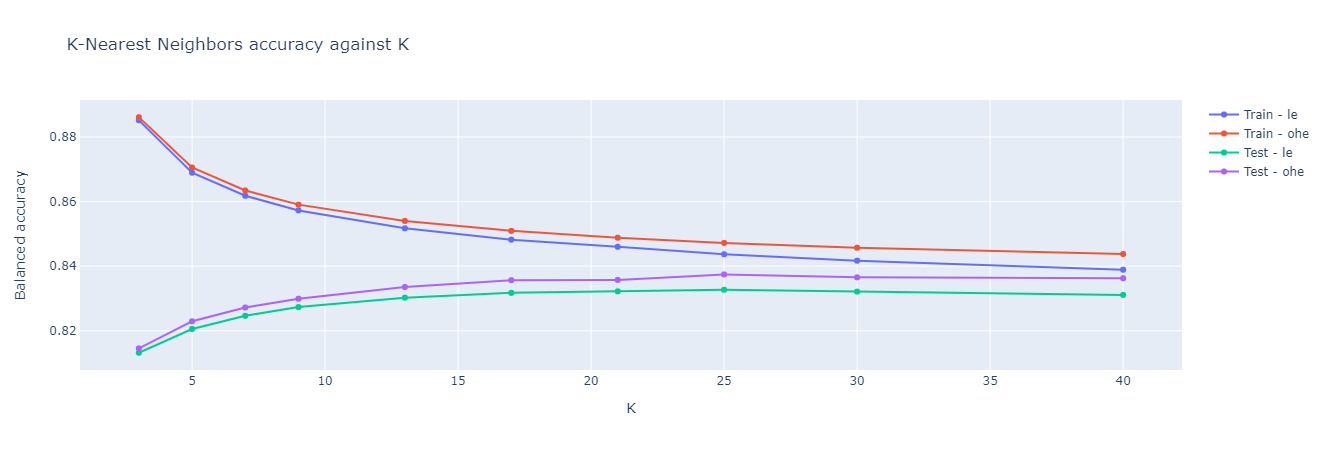

In [4]:
acc_analysis(datasets, knn, 'n_neighbors').update_layout(xaxis_title="K", yaxis_title="Balanced accuracy", title="K-Nearest Neighbors accuracy against K")

<span id="knn-testing" />

### Testing

Testing the best models of each *\"feature engineering type\"*, we obtain the accuracies reported in the plot below.

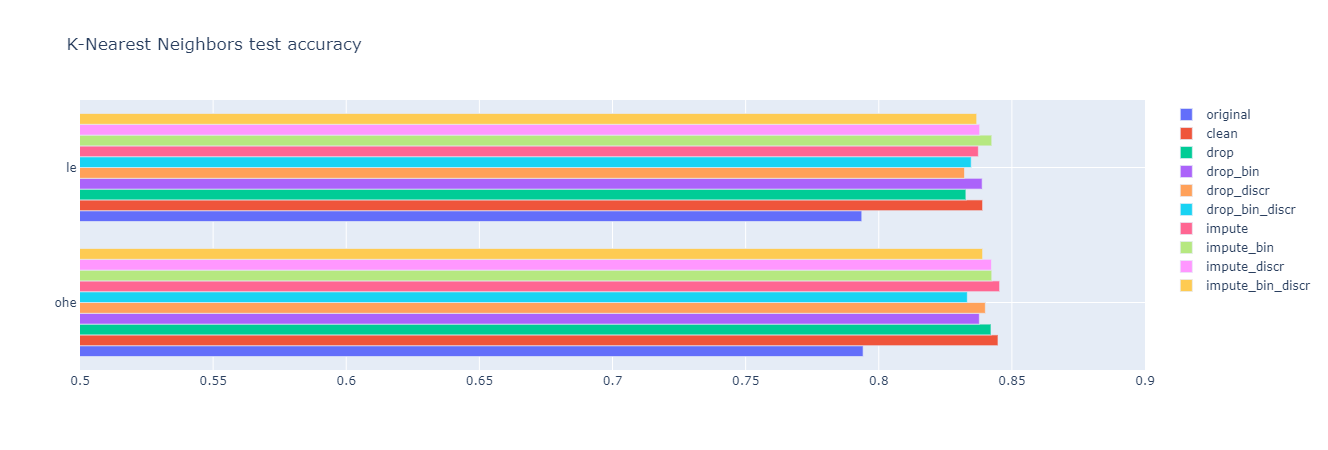

Best model:


KNeighborsClassifier(n_neighbors=25)

In [12]:
# Plot
plot_results(knn_results, "K-Nearest Neighbors test accuracy").show()
print("Best model:")
knn["impute"]["model_ohe"]

<span id="knn-conclusions" />

### Conclusions

Even though our dataset has a lot of features, KNN managed to achieve good accuracies thanks to the sklearn implementation.

## Decision Trees

<span id="dt-theory" />

### Theory recall

Decision tree models stratify the predictors space into simpler regions in order to make predictions. The assigned class is simply the most probable inside that region.

The most difficult part is therefore the definition of the tree and the *split criterions*. The main idea behind the definition of a *split criterion* is to generate splits where there is a low *mixing* of class variables. Hence, we need to define a measure for this *mixing* and then generate all the splits recursively.

Of course, the model stops when the level of *mixing* inside a branch is below a given threshold. In this way, the risk of overfitting is reduced. On the other hand, stopping too soon may result in underfitting.

The two most common measures of impurity are:

- Gini index: $G(node)=1-\sum\limits_{k=1}^{K}p\left(k|node\right)^{2}$ which is a measure of total variance across the $K$ classes in the node
- Cross-entropy: $D=-\sum\limits_{k=1}^{K}p\left(k|node\right)log\left(p\left(k|node\right)\right)$

The main advantages of this model are:

- Simple and interpretable
- Almost no need of data preparation (can handle categorical variables)

On the other hand, the main disadvantages are:

- Can overfit pretty easily
- Not very accurate with respect to other supervised models (however, despite decreasing the interpretability, aggregating trees can solve this problem; see [Random Forest](#Random-Forest))
- Affected by unbalanced target classes

<span id="dt-parameters" />

### Parameters

With the grid search, the following parameters have been optimized:

- *criterion*: the split criterion used to measure the level of impurity of a split
- *max_depth*: the maximum depth of the tree (to control overfitting)

In [13]:
# Decision trees
dt, dt_results = train_and_test(
    datasets,
    DecisionTreeClassifier(),
    [{'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 5, 6, 8, 12, 15, 18, 22, 26]}]
)

If we analyse how the accuracy evolves changing the *max_depth* parameter, we can notice the following things:

- when the parameter is too small, the tree underfits (only one split)
- when the parameter is around 8, the accuracy on the test set is around his maximum
- increasing too much the parameter makes the tree overfitting

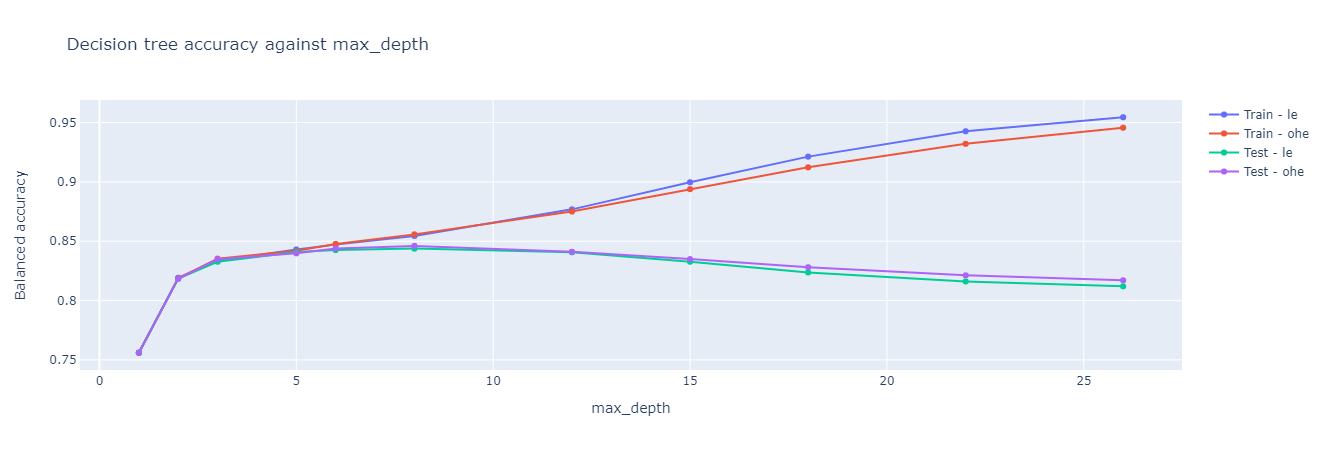

In [29]:
acc_analysis(datasets, dt, 'max_depth').update_layout(xaxis_title="max_depth", yaxis_title="Balanced accuracy", title="Decision tree accuracy against max_depth")

<span id="knn-testing" />

### Testing

Testing the best models of each *\"feature engineering type\"*, we obtain the accuracies reported in the plot below.

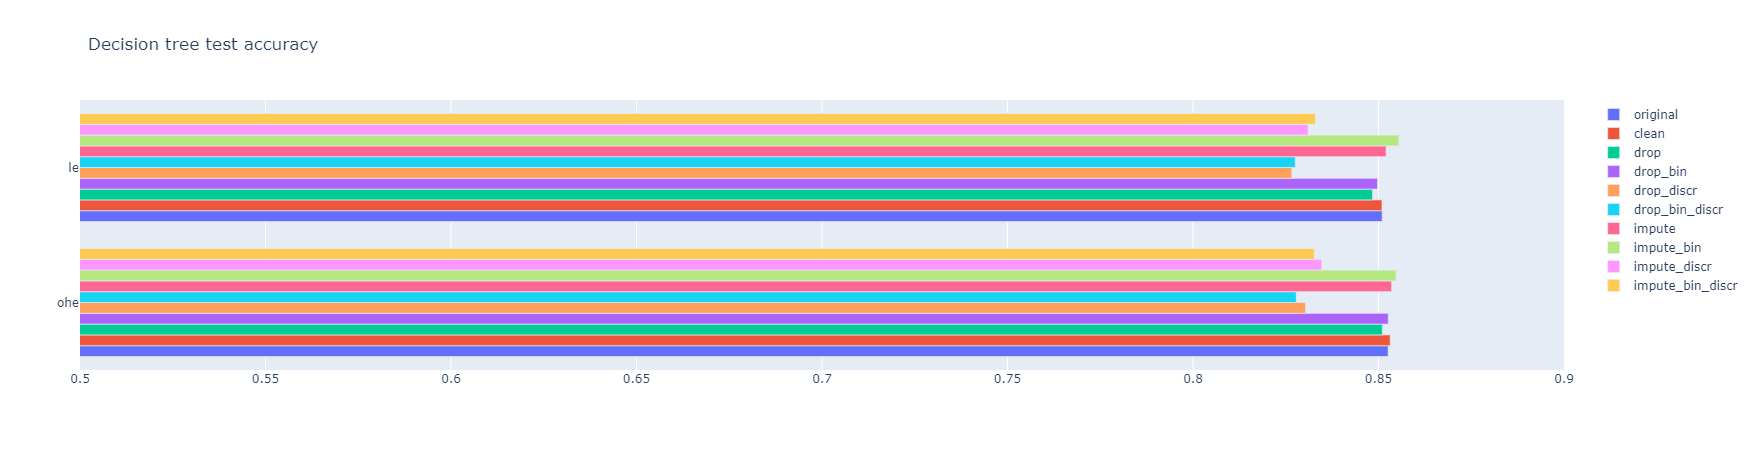

Best model:


DecisionTreeClassifier(max_depth=8)

In [24]:
# Plot
plot_results(dt_results, "Decision tree test accuracy").show()
print("Best model:")
dt["impute_bin"]["model_le"]

<span id="dt-conclusions" />

### Conclusions

As we can see from the following plot:

- since the decision trees can handle categorical features, the best performing datasets have been the label encoded ones
- it is interesting how discretizing variables decreases the performance of the trees

## Random Forest

<span id="rf-theory" />

### Theory recall

Random forest models are ensemble of decision trees: the main idea is to generate multiple decision trees and take as output the average of the output of all the trees. The tree algorithm of random forests is a little bit different: at each candidate split in the learning process, only a random subset of the features is selected (usually $\sqrt p$ where $p$ is the number of predictors).

The main advantage of this algorithm is that the different trees are decorrelated, thus reducing the mean variance of the observed data.

<span id="rf-parameters-trees" />

### Parameters (trees)

To begin with, I have looked for the best number of candidate trees using the best max_depth found with a single decision tree. Then, using the best number of trees, I have optimized the max depth of the trees. 

In [16]:
# Random forest
rf, rf_results = train_and_test(
    datasets,
    RandomForestClassifier(max_depth=8),
    [{'n_estimators': [1, 10, 50, 100, 150], 'criterion': ['gini', 'entropy']}]
)

If we analyse how the accuracy evolves changing the *n_estimators* parameter, we can notice the following things:

- using too few trees, the real potential of random forests is not exploited
- when the number of trees increases, the effects of random forests start to be noticed

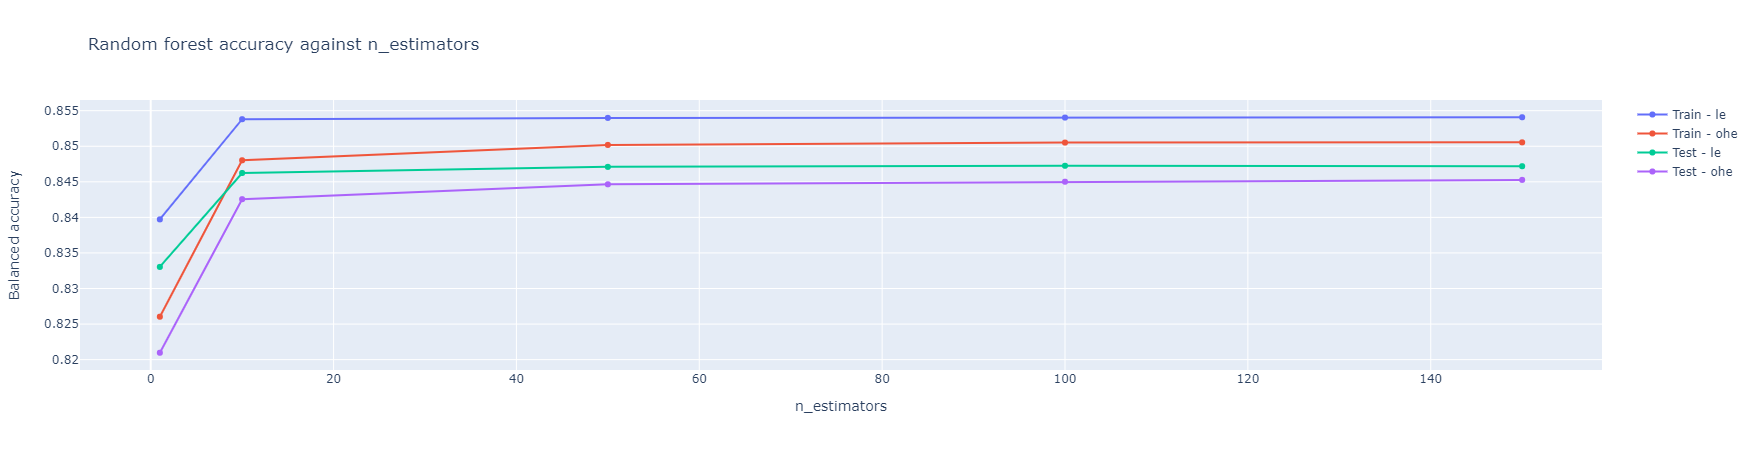

In [25]:
acc_analysis(datasets, rf, 'n_estimators').update_layout(xaxis_title="n_estimators", yaxis_title="Balanced accuracy", title="Random forest accuracy against n_estimators")

<span id="rf-testing-trees" />

### Testing (trees)

Testing the best models of each *\"feature engineering type\"*, we obtain the accuracies reported in the plot below.

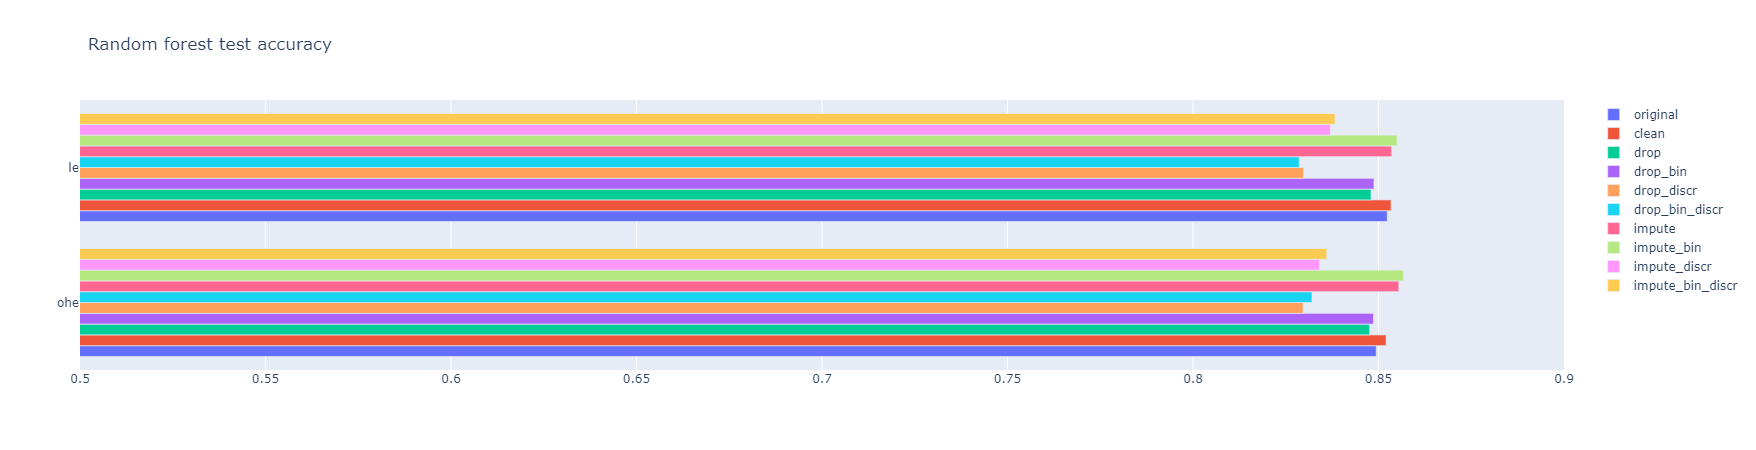

Best model:


DecisionTreeClassifier(criterion='entropy', max_depth=8)

In [26]:
# Plot
plot_results(rf_results, "Random forest test accuracy").show()
print("Best model:")
dt["impute_bin"]["model_ohe"]

<span id="rf-parameters-depth" />

### Parameters (depth)

We can now try to optimize the depth of the trees.

In [19]:
# Random forest depth
rf_depth, rf_results_depth = train_and_test(
    datasets,
    RandomForestClassifier(n_estimators=100),
    [{'max_depth': [1, 3, 6, 8, 12, 15], 'criterion': ['gini', 'entropy']}]
)

If we analyse how the accuracy evolves changing the *max_depth* parameter, we can notice the following things:

- when the parameter is too small, the tree underfits (only one split)
- when the parameter is around 12, the accuracy on the test set is around his maximum
- increasing too much the parameter makes the tree overfitting

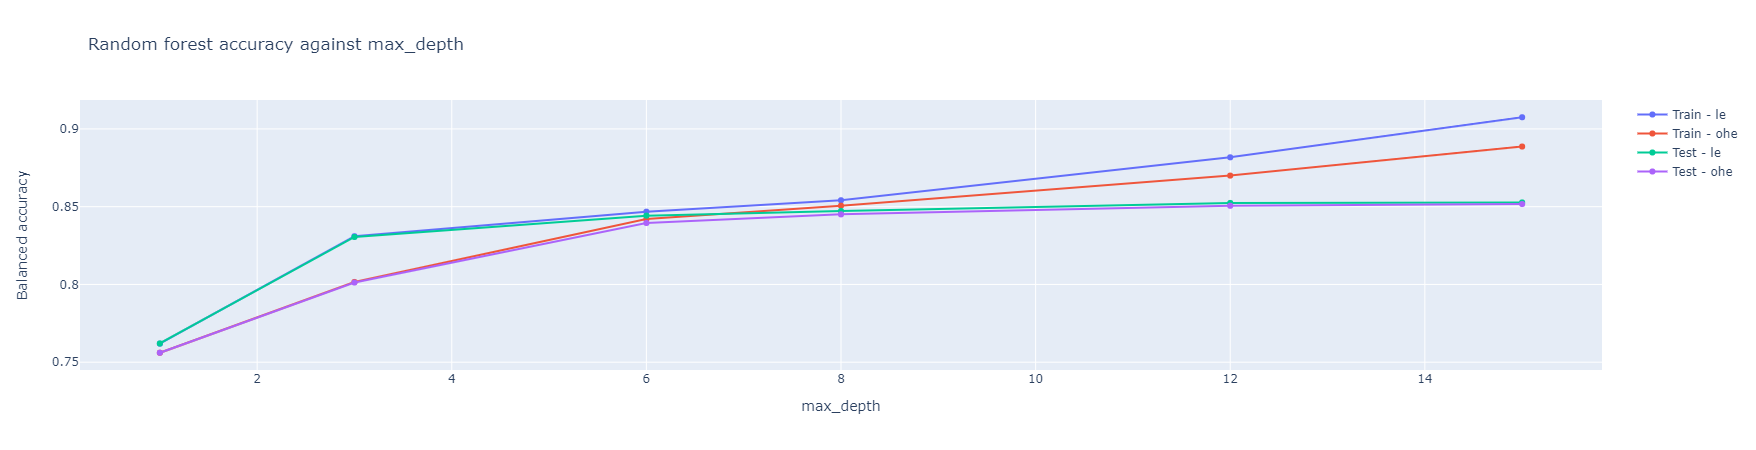

In [27]:
acc_analysis(datasets, rf_depth, "max_depth").update_layout(xaxis_title="max_depth", yaxis_title="Balanced accuracy", title="Random forest accuracy against max_depth")

<span id="rf-testing-depth" />

### Testing (depth)

Testing the best models of each *\"feature engineering type\"*, we obtain the accuracies reported in the plot below.

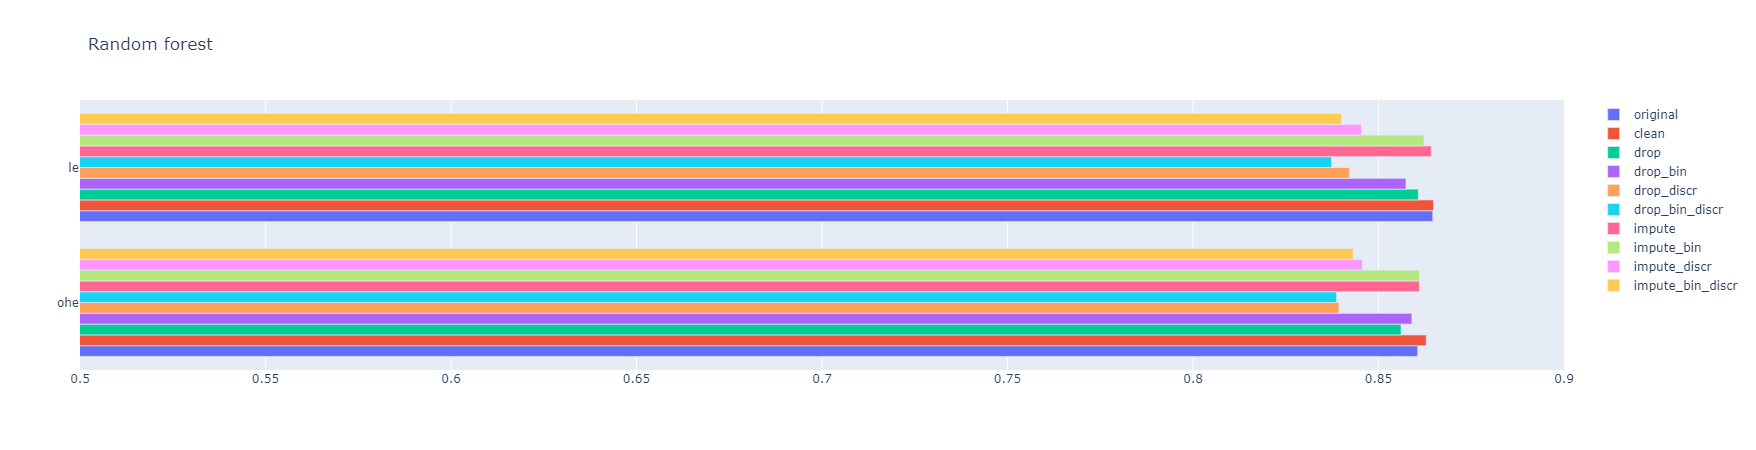

Best model:


DecisionTreeClassifier(criterion='entropy', max_depth=8)

In [28]:
# Plot
plot_results(rf_results_depth, "Random forest").show()
print("Best model:")
dt["clean"]["model_le"]

<span id="rf-conclusions" />

### Conclusions

The Random Forest algorithm, with 8 maximum depth and 100 candidate tress, is the best model for the given dataset. In fact, it has achieved an accuracy of 86,5% on the test set using label encoding and imputation.

## Future Work

I think that achieving around 86,5% accuracy can be considered pretty good given the difficulty of dataset. Nonetheless, I am aware the there are multiple ways to maybe improve the current models. The following possibilities of improving the models are left for the future:

- try different metrics to bettere evaluate the parameters
- try other combinations of feature engineering and maybe also different techniques
- try to implement a feature selection or dimensionality reduction algorithm